# Model_RandomForest.ipynb

**Goal:** Explore nonlinear relationships and feature importance.

This notebook creates a Random Forest model using processed_online_shoppers_data.csv. This involves:

1. Loading the data
2. Performing a stratified train-test split
3. Training a RandomForestClassifier with GridSearchCV to find optimal hyperparameters
4. Record optimal hyperparameters and cross-validation accuracy
5. Plotting feature importances and the ROC curve
6. Saving the model as a .pkl file and its performance metrics and hyperparameters to rf_results.csv

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay
)
 
import joblib
 
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# 1) Load Processed Data

In [2]:
FILENAME = "processed_online_shoppers_data.csv"
df = pd.read_csv(FILENAME)
print(f"Loaded dataset from: {FILENAME}")
print("Shape:", df.shape)
df.head()

Loaded dataset from: processed_online_shoppers_data.csv
Shape: (12330, 39)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Region,TrafficType,Total_Time,Is_SpecialDay,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Revenue
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.233426,-0.894178,-0.762629,-0.642894,-0.33603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,-0.136078,-0.894178,-0.514182,-0.611486,-0.33603,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,2.058618,2.437081,-0.265735,-0.642894,-0.33603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,0.961270,-0.477771,-0.017289,-0.641585,-0.33603,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,0.961270,-0.894178,-0.017289,-0.334952,-0.33603,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False


# 2) Train/Test Split (Stratified)

In [3]:
X = df.drop("Revenue", axis=1)
y = df["Revenue"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


# 3)Train Random Forest with GridSearchCV

In [4]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0 # Changed from 2 to 0 to suppress output
)

grid_search.fit(X_train, y_train)


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


# 4) Record optimal hyperparameters and cross-validation accuracy

In [5]:
print(f"Best hyperparameters: {grid_search.best_params_}")
 
print(f"Best cross-validation ROC-AUC: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics directly
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, zero_division=0)
rf_recall = recall_score(y_test, y_pred, zero_division=0)
rf_f1 = f1_score(y_test, y_pred, zero_division=0)
rf_roc_auc = roc_auc_score(y_test, y_proba)

# Store in a dictionary for consistency with later steps
rf_metrics = {
    "accuracy": rf_accuracy,
    "precision": rf_precision,
    "recall": rf_recall,
    "f1": rf_f1,
    "roc_auc": rf_roc_auc
}

print(f"Random Forest - Test Accuracy: {rf_accuracy:.2%}")
print(f"Random Forest - Test ROC-AUC : {rf_roc_auc:.2f}")

Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation ROC-AUC: 0.9308
Random Forest - Test Accuracy: 89.13%
Random Forest - Test ROC-AUC : 0.92


# 5)Plot feature importances and ROC curve

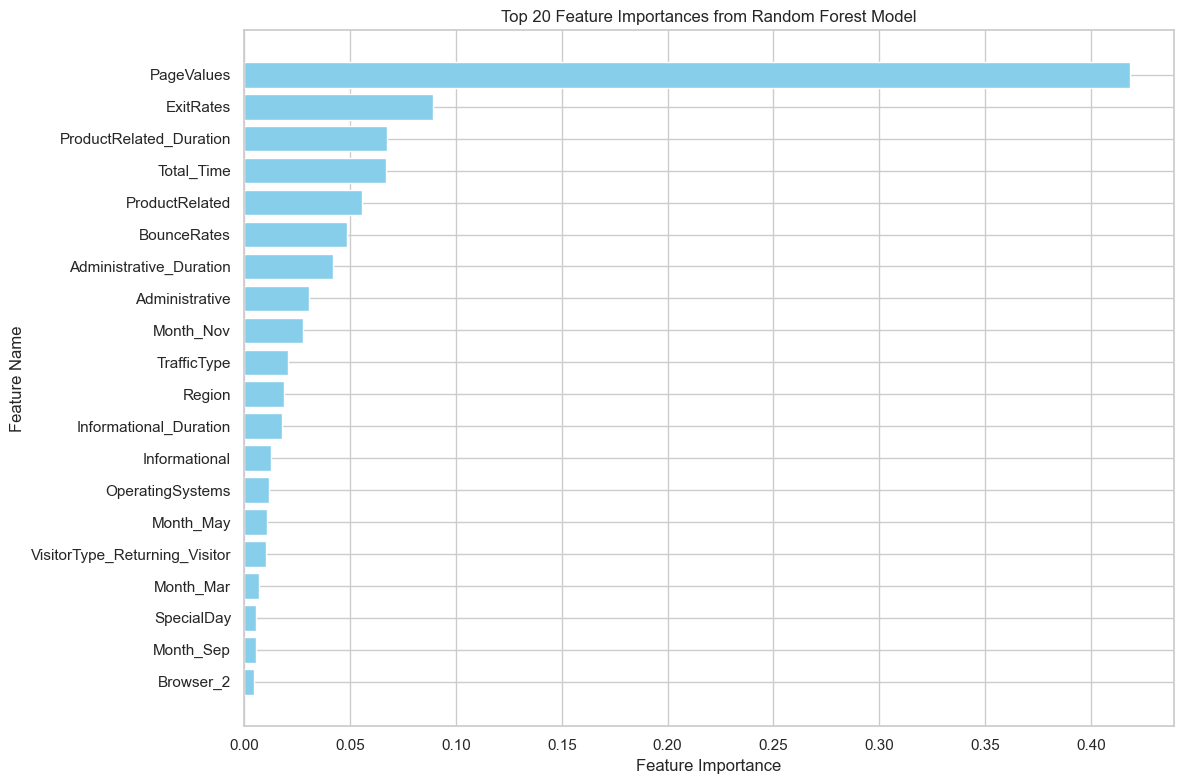

In [6]:
# Plot feature importances 

feature_importances = best_rf_model.feature_importances_
 
feature_names = X_train.columns

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot top N features
N = 20 # Adjustable feature number
plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'].head(N), importance_df['importance'].head(N), color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title(f'Top {N} Feature Importances from Random Forest Model')
plt.gca().invert_yaxis() # Highest importance at the top
plt.tight_layout()
plt.show()

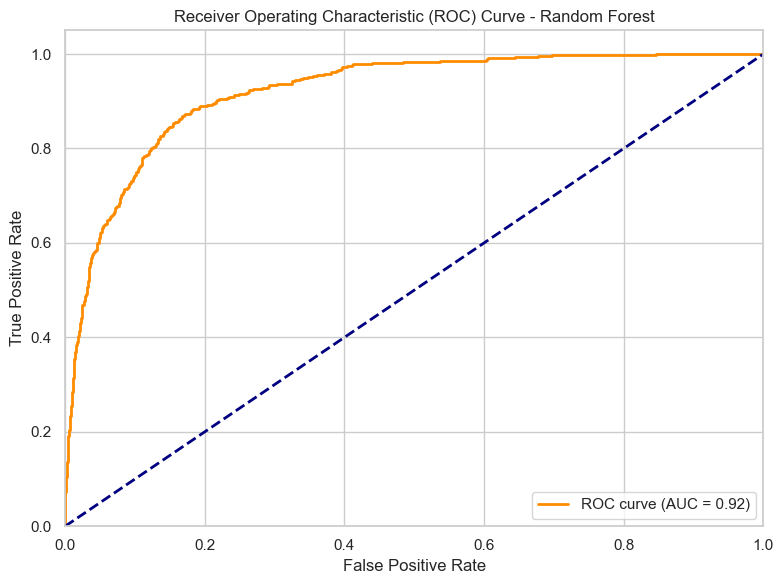

In [7]:
# Plot ROC curve 

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = rf_metrics['roc_auc']

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) Save model and metrics 

In [8]:
# Save the best Random Forest model
rf_model_path = "rf_best_model.pkl"
joblib.dump(best_rf_model, rf_model_path)
print(f"Saved best Random Forest model to: {rf_model_path}")

# Prepare metrics and best hyperparameters for saving
results_data = {
    "model": "RandomForest_GridSearchCV",
    **rf_metrics,
    "best_n_estimators": grid_search.best_params_['n_estimators'],
    "best_max_depth": grid_search.best_params_['max_depth'],
    "best_min_samples_split": grid_search.best_params_['min_samples_split']
}

results_df = pd.DataFrame([results_data])

# Save metrics and hyperparameters to CSV
out_csv = "rf_results.csv"
results_df.to_csv(out_csv, index=False)
print("Saved metrics and best hyperparameters to:", out_csv)

print("\n--- Model Performance Summary ---")
print(f"Best Random Forest Model (tuned with GridSearchCV) achieved the following on the test set:")
print(f"  Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"  Precision: {rf_metrics['precision']:.4f}")
print(f"  Recall: {rf_metrics['recall']:.4f}")
print(f"  F1-Score: {rf_metrics['f1']:.4f}")
print(f"  ROC-AUC: {rf_metrics['roc_auc']:.4f}")
print(f"Optimal Hyperparameters: {grid_search.best_params_}")
results_df

Saved best Random Forest model to: rf_best_model.pkl
Saved metrics and best hyperparameters to: rf_results.csv

--- Model Performance Summary ---
Best Random Forest Model (tuned with GridSearchCV) achieved the following on the test set:
  Accuracy: 0.8913
  Precision: 0.6466
  Recall: 0.6556
  F1-Score: 0.6510
  ROC-AUC: 0.9207
Optimal Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}


,model,accuracy,precision,recall,f1,roc_auc,best_n_estimators,best_max_depth,best_min_samples_split
0,RandomForest_GridSearchCV,0.891322,0.646552,0.655594,0.651042,0.920668,300,None,10
